In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv


In [3]:
! pip install iterative-stratification

In [207]:
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau



import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, tnrange

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

plt.rcParams['figure.figsize'] = 15, 7

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [208]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [303]:

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')


In [304]:
def preprocess(df):
    df = df.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    return df

train = preprocess(train_features)
test = preprocess(test_features)

del train_targets['sig_id']

target = train_targets.loc[train['cp_type']==0].reset_index(drop=True)
train = train.loc[train['cp_type']==0].reset_index(drop=True)

In [305]:
top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

In [306]:
all_columns = train.columns
train=train[all_columns[top_features]]
test = test[all_columns[top_features]]

In [307]:
train = train.values
test = test.values
target = target.values


In [308]:
train.shape, test.shape, target.shape

((21948, 785), (3982, 785), (21948, 206))

In [309]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float()
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature, target

In [216]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

## Train test split for testing 

In [217]:
def validate_fn(model, val_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch 
            pred = model(x.to(device))
            loss = criterion(pred.cpu(),y).item()
            losses.append(loss)
    return np.array(losses).mean()

def create_weights_from_val_losses(val_losses_np):
    w = 1/val_losses_np
    w_norm = w/w.max()
    return w_norm


def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            
            if scheduler is not None:
                scheduler.step(1.)   ## lr decay caller 

            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            val_losses.append(validate_fn(model, val_loader, criterion, device))
            

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]
                name = "./model_" + str(fold_number)+".pth"
                print("saving model as: ", name)
                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    if train == True:
        return min(val_losses), name
    else:
        return min(val_losses)

In [373]:


full_dataset = TrainDataset(train, target, noise = False)

train_size = int(0.9* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 512, shuffle = False)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

155 batches 
5  batches 


# Model 1 

In [374]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [375]:
model_filenames = []
val_losses = []

# Model 1 training 

In [376]:
num_epochs = 45 ## changes here 

model = Model()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.004299882049752947, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1, ## wooo hoo
                                                 patience=7, ## was 3 for 158 
                                                 eps=1e-4, 
                                                 verbose=True)


criterion = nn.BCEWithLogitsLoss()

val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1)

val_losses.append(val_loss)
model_filenames.append(filename)
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  45      > Val loss decreased from: 1000000  to  0.021068791300058363    >saving model as:  ./model_1.pth
epoch  2  out of  45      > Val loss decreased from: 0.021068791300058363  to  0.019239036738872527    >saving model as:  ./model_1.pth
epoch  3  out of  45      > Val loss decreased from: 0.019239036738872527  to  0.018405894935131072    >saving model as:  ./model_1.pth
epoch  4  out of  45      > Val loss decreased from: 0.018405894935131072  to  0.01796437203884125    >saving model as:  ./model_1.pth
epoch  5  out of  45      > Val loss decreased from: 0.01796437203884125  to  0.017606330662965776    >saving model as:  ./model_1.pth
epoch  6  out of  45      > Val loss decreased from: 0.017606330662965776  to  0.017410482466220855    >saving model as:  ./model_1.pth
epoch  7  out of  45      > Val loss decreased from: 0.017410482466220855  to  0.017244889587163924    >saving model as:  ./model_1.pth
epoch  8  out of  45      >showing no improvements, best loss y

In [377]:
model_filenames

['./model_1.pth']

# Model 2 

In [378]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(785)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(785, 512))
        
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(512, 206))
    
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = self.dense4(x)
        
        return x

# Model 2 training

In [379]:
num_epochs = 45 ## changes here 

model = Model_2()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 4e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1, ## wooo hoo
                                                 patience=7, ## was 3 for 158 
                                                 eps=1e-4, 
                                                 verbose=True)


criterion = nn.BCEWithLogitsLoss()

val_loss, filename = train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 100)


val_losses.append(val_loss)
model_filenames.append(filename)
    
    
print(CBLUE, "Training complete", CEND)

epoch  1  out of  45      > Val loss decreased from: 1000000  to  0.021287448704242706    >saving model as:  ./model_100.pth
epoch  2  out of  45      > Val loss decreased from: 0.021287448704242706  to  0.019070076942443847    >saving model as:  ./model_100.pth
epoch  3  out of  45      > Val loss decreased from: 0.019070076942443847  to  0.01837366335093975    >saving model as:  ./model_100.pth
epoch  4  out of  45      > Val loss decreased from: 0.01837366335093975  to  0.017764350026845933    >saving model as:  ./model_100.pth
epoch  5  out of  45      > Val loss decreased from: 0.017764350026845933  to  0.017516466230154036    >saving model as:  ./model_100.pth
epoch  6  out of  45      > Val loss decreased from: 0.017516466230154036  to  0.017311893031001092    >saving model as:  ./model_100.pth
epoch  7  out of  45      > Val loss decreased from: 0.017311893031001092  to  0.01717060022056103    >saving model as:  ./model_100.pth
epoch  8  out of  45      > Val loss decreased fro

# Model blending

In [380]:
class blend(nn.Module):
    def __init__(self,weights, model_list ,model_filenames, device = device):
        super(blend, self).__init__()
#         print("loading models...")
        self.model_filenames = model_filenames
        self.model_list = model_list
        self.weights = weights 

        for i in range(len(self.model_filenames)):
            self.model_list[i].load_state_dict(torch.load(self.model_filenames[i]))
            self.model_list[i].to(device)
            self.model_list[i].eval()
            
#         print("done loading from", self.model_filenames)

    def forward(self, x):
        
        x_list = [self.model_list[i](x).detach().cpu() for i in range(len(self.model_list))]
        
        final_pred = torch.zeros_like(x_list[0])
        for i in range(len(x_list)):
            final_pred += x_list[i] * self.weights[i]
            
        final_pred = final_pred/self.weights.sum()
        
        return final_pred.cpu()

In [381]:
weights = create_weights_from_val_losses(np.array(val_losses))
bb = blend(
    weights = weights, 
    model_list = [Model(), Model_2()],
    model_filenames = model_filenames
)

In [382]:
model_filenames

['./model_1.pth', './model_100.pth']

In [383]:
all_models = [Model(), Model_2()]
test_val_losses = {}

for i in range(len(model_filenames)):
    all_models[i].load_state_dict(torch.load(model_filenames[i]))
    all_models[i].to(device)
    all_models[i].eval()
    
all_val_losses = []

with torch.no_grad():
    for i in range(len(all_models)):
        val_loss = validate_fn(all_models[i], val_loader, criterion, device)
        test_val_losses["model_" + str(i+1)] = val_loss
    print("done validating")

test_val_losses

done validating


{'model_1': 0.015834295190870762, 'model_2': 0.01613880954682827}

In [385]:
val_loss = validate_fn(bb, val_loader, criterion, device)
test_val_losses["model_blend"] = val_loss



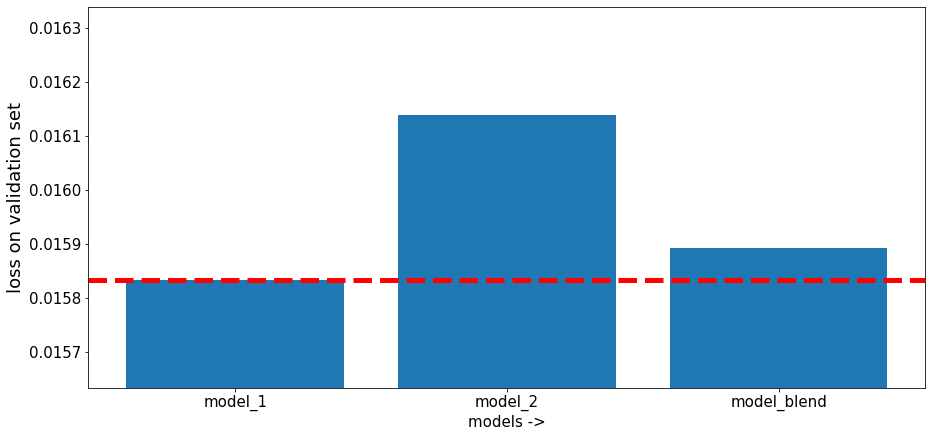

In [386]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

plt.bar(names, vals)
plt.ylim(min(vals)- .0002, max(vals) + 0.0002)
plt.ylabel("loss on validation set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.show()

# Finding good weights, better than the ones made from val losses 

In [387]:
import optuna

In [388]:
def validate_trial( val_loader, criterion, device, params):
    bb = blend(
    weights = np.array([params["w1"], params["w2"]]), 
    model_list = [Model(), Model_2()],
    model_filenames = model_filenames
    )
    
    loss_ = validate_fn(bb,val_loader, criterion, device)
    return loss_

In [389]:
def objective(trial):
    params = {
        "w1": trial.suggest_uniform("w1", 0.001, 1.0),
        "w2": trial.suggest_uniform("w2", 0.001, 1.0)
    }
    loss_ = validate_trial(val_loader,criterion, device, params)
    return loss_


In [390]:
study = optuna.create_study(direction="minimize")


[I 2020-10-01 05:27:45,813] A new study created in memory with name: no-name-ce727115-8dcc-41d3-b728-257245932fa1


In [391]:
study.optimize(objective, n_trials=400)



[I 2020-10-01 05:27:47,303] Trial 0 finished with value: 0.016004518419504166 and parameters: {'w1': 0.15051765946156137, 'w2': 0.5079892092830627}. Best is trial 0 with value: 0.016004518419504166.
[I 2020-10-01 05:27:47,498] Trial 1 finished with value: 0.015901945903897284 and parameters: {'w1': 0.5328091143362652, 'w2': 0.5820717017698599}. Best is trial 1 with value: 0.015901945903897284.
[I 2020-10-01 05:27:47,699] Trial 2 finished with value: 0.015894747525453567 and parameters: {'w1': 0.2738097823192691, 'w2': 0.2728192631834364}. Best is trial 2 with value: 0.015894747525453567.
[I 2020-10-01 05:27:47,899] Trial 3 finished with value: 0.016108262166380883 and parameters: {'w1': 0.03893352424642978, 'w2': 0.7976909704814051}. Best is trial 2 with value: 0.015894747525453567.
[I 2020-10-01 05:27:48,111] Trial 4 finished with value: 0.01583998966962099 and parameters: {'w1': 0.9769746314298314, 'w2': 0.3057957937636394}. Best is trial 4 with value: 0.01583998966962099.
[I 2020-10

[I 2020-10-01 05:27:56,137] Trial 41 finished with value: 0.01583130843937397 and parameters: {'w1': 0.6443878197751993, 'w2': 0.05751796124266395}. Best is trial 41 with value: 0.01583130843937397.
[I 2020-10-01 05:27:56,343] Trial 42 finished with value: 0.01583160776644945 and parameters: {'w1': 0.6658949497250705, 'w2': 0.041825497331848205}. Best is trial 41 with value: 0.01583130843937397.
[I 2020-10-01 05:27:56,548] Trial 43 finished with value: 0.01583233866840601 and parameters: {'w1': 0.7886222532029799, 'w2': 0.12787559547864152}. Best is trial 41 with value: 0.01583130843937397.
[I 2020-10-01 05:27:56,756] Trial 44 finished with value: 0.015833649039268493 and parameters: {'w1': 0.5625173295624957, 'w2': 0.0056300359598183275}. Best is trial 41 with value: 0.01583130843937397.
[I 2020-10-01 05:27:56,960] Trial 45 finished with value: 0.015843936800956727 and parameters: {'w1': 0.6422265784100034, 'w2': 0.23715334414916678}. Best is trial 41 with value: 0.01583130843937397.


[I 2020-10-01 05:28:04,410] Trial 81 finished with value: 0.01583162136375904 and parameters: {'w1': 0.583235242664516, 'w2': 0.0769308884897684}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:04,693] Trial 82 finished with value: 0.015831921622157095 and parameters: {'w1': 0.6998589857846493, 'w2': 0.1024417502806031}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:04,908] Trial 83 finished with value: 0.015832125395536422 and parameters: {'w1': 0.5442801766683689, 'w2': 0.02350676135964928}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:05,136] Trial 84 finished with value: 0.015831311233341694 and parameters: {'w1': 0.6471061284315204, 'w2': 0.05738225057231993}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:05,345] Trial 85 finished with value: 0.015831412002444267 and parameters: {'w1': 0.6414419906292201, 'w2': 0.04842448247383075}. Best is trial 56 with value: 0.015831296890974046.

[I 2020-10-01 05:28:12,727] Trial 121 finished with value: 0.015831311978399754 and parameters: {'w1': 0.5800224234721768, 'w2': 0.05123989317813242}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:12,928] Trial 122 finished with value: 0.015832495503127576 and parameters: {'w1': 0.6162171775039145, 'w2': 0.020396675910044557}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:13,132] Trial 123 finished with value: 0.015831358544528485 and parameters: {'w1': 0.5597631169067764, 'w2': 0.04522663997208413}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:13,345] Trial 124 finished with value: 0.01583180371671915 and parameters: {'w1': 0.5739826768895269, 'w2': 0.0310952981165696}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:13,543] Trial 125 finished with value: 0.015834144689142703 and parameters: {'w1': 0.5548330965246557, 'w2': 0.001237047697630278}. Best is trial 56 with value: 0.0158312968

[I 2020-10-01 05:28:21,433] Trial 161 finished with value: 0.015861270390450953 and parameters: {'w1': 0.6546757147546008, 'w2': 0.38314579708750796}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:21,640] Trial 162 finished with value: 0.01583131607621908 and parameters: {'w1': 0.6178526164341911, 'w2': 0.053907598499400626}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:21,846] Trial 163 finished with value: 0.015834129974246026 and parameters: {'w1': 0.6019009244824292, 'w2': 0.001474979550449361}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:22,051] Trial 164 finished with value: 0.01583164036273956 and parameters: {'w1': 0.6159959029945407, 'w2': 0.03773306557998737}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:22,260] Trial 165 finished with value: 0.01583279948681593 and parameters: {'w1': 0.6951930744846393, 'w2': 0.01817789576645632}. Best is trial 56 with value: 0.01583129689

[I 2020-10-01 05:28:29,988] Trial 201 finished with value: 0.015831297263503075 and parameters: {'w1': 0.5824383411770898, 'w2': 0.05546871086728511}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:30,290] Trial 202 finished with value: 0.015831402316689492 and parameters: {'w1': 0.575829676331002, 'w2': 0.06689456823510241}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:30,496] Trial 203 finished with value: 0.01583139207214117 and parameters: {'w1': 0.5940952625470906, 'w2': 0.045868424780723394}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:30,704] Trial 204 finished with value: 0.015832225419580938 and parameters: {'w1': 0.5467440270462368, 'w2': 0.08647647812383294}. Best is trial 56 with value: 0.015831296890974046.
[I 2020-10-01 05:28:30,918] Trial 205 finished with value: 0.015831305645406246 and parameters: {'w1': 0.6192036521377525, 'w2': 0.06285614911963139}. Best is trial 56 with value: 0.01583129689

[I 2020-10-01 05:28:38,664] Trial 241 finished with value: 0.015831544250249862 and parameters: {'w1': 0.7595837518227481, 'w2': 0.05039006967737436}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:38,881] Trial 242 finished with value: 0.015832051075994967 and parameters: {'w1': 0.7159604017113848, 'w2': 0.032575421397411146}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:39,186] Trial 243 finished with value: 0.01583133712410927 and parameters: {'w1': 0.7374806416552472, 'w2': 0.06179925432511173}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:39,397] Trial 244 finished with value: 0.0158316645771265 and parameters: {'w1': 0.7861138007203794, 'w2': 0.047236875253375846}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:39,611] Trial 245 finished with value: 0.01583130657672882 and parameters: {'w1': 0.7016023419382025, 'w2': 0.07125946683043004}. Best is trial 229 with value: 0.01583129558

[I 2020-10-01 05:28:47,718] Trial 281 finished with value: 0.01583130657672882 and parameters: {'w1': 0.7325411021689274, 'w2': 0.07441606289761721}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:47,921] Trial 282 finished with value: 0.015831602551043034 and parameters: {'w1': 0.7906517973950569, 'w2': 0.04984556296492356}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:48,127] Trial 283 finished with value: 0.015832560881972314 and parameters: {'w1': 0.564327250291566, 'w2': 0.09553088545615925}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:48,513] Trial 284 finished with value: 0.015832836180925368 and parameters: {'w1': 0.959960508441469, 'w2': 0.0243045687813715}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:48,815] Trial 285 finished with value: 0.015831508859992027 and parameters: {'w1': 0.7687820028413888, 'w2': 0.05269044797764995}. Best is trial 229 with value: 0.0158312955871

[I 2020-10-01 05:28:57,050] Trial 321 finished with value: 0.015832042694091795 and parameters: {'w1': 0.8427223835816078, 'w2': 0.038574455491624145}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:57,261] Trial 322 finished with value: 0.015832059644162656 and parameters: {'w1': 0.5529729735442466, 'w2': 0.08408791712386368}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:57,467] Trial 323 finished with value: 0.01583131533116102 and parameters: {'w1': 0.628853406777915, 'w2': 0.0552398432119922}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:57,674] Trial 324 finished with value: 0.01583244279026985 and parameters: {'w1': 0.5963570939566525, 'w2': 0.09870979692971649}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:28:57,896] Trial 325 finished with value: 0.015831320360302926 and parameters: {'w1': 0.7850125939574147, 'w2': 0.06792246640093937}. Best is trial 229 with value: 0.015831295587

[I 2020-10-01 05:29:05,944] Trial 361 finished with value: 0.01583133954554796 and parameters: {'w1': 0.904466370357052, 'w2': 0.0982148692811535}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:29:06,158] Trial 362 finished with value: 0.01583319567143917 and parameters: {'w1': 0.8995356293568465, 'w2': 0.1684896969475136}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:29:06,372] Trial 363 finished with value: 0.015848333947360516 and parameters: {'w1': 0.9416296186457923, 'w2': 0.4021688667505292}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:29:06,589] Trial 364 finished with value: 0.015831298567354678 and parameters: {'w1': 0.8893587521587174, 'w2': 0.08295208746895776}. Best is trial 229 with value: 0.01583129558712244.
[I 2020-10-01 05:29:06,899] Trial 365 finished with value: 0.015831313282251357 and parameters: {'w1': 0.8868201145361447, 'w2': 0.0919386468234964}. Best is trial 229 with value: 0.0158312955871224

In [392]:
print("best_trial:")
best_trial = study.best_trial
best_trial.params

best_trial:


{'w1': 0.7294536413552165, 'w2': 0.06924639830655917}

In [393]:
noice_weights = np.array([
    best_trial.params["w1"], 
    best_trial.params["w2"]
])


bb = blend(
    weights = noice_weights, 
    model_list = [Model(), Model_2()],
    model_filenames = model_filenames
)

In [394]:
val_loss_op = validate_fn(bb, val_loader, criterion, device)
test_val_losses["blend_with_optuna"] = val_loss_op
test_val_losses

{'model_1': 0.015834295190870762,
 'model_2': 0.01613880954682827,
 'model_blend': 0.01589357666671276,
 'blend_with_optuna': 0.01583129558712244}

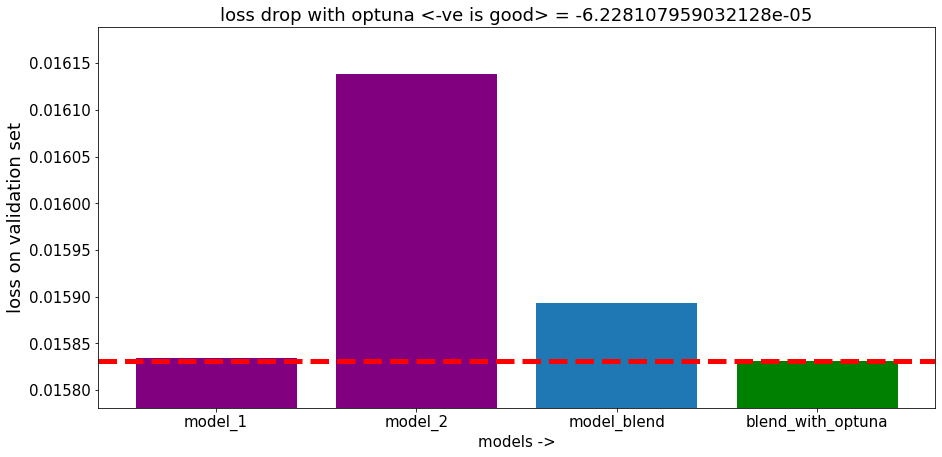

In [395]:
plt.rcParams.update({'font.size': 15})

names = test_val_losses.keys()
vals = test_val_losses.values()

bars = plt.bar(names, vals)
bars[0].set_color("purple")
bars[1].set_color("purple")
bars[-1].set_color("g")
plt.ylim(min(vals)- .00005, max(vals) + 0.00005)
plt.ylabel("loss on validation set", fontsize = 18)
plt.xlabel("models ->", fontsize = 15)
plt.axhline(y = min(vals), linestyle = "--", c = "r", linewidth = 5)
plt.title("loss drop with optuna <-ve is good> = " + str(test_val_losses["blend_with_optuna"] - test_val_losses["model_blend"]) + "  Best loss: " + str(test_val_losses["blend_with_optuna"]))
plt.show()